In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("data/raw/"))

# Any results you write to the current directory are saved as output.

['test_images', 'depths.csv', 'train.csv', 'sample_submission.csv', '.ipynb_checkpoints', 'train_images']


In [2]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img

/home/endi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# 指定需要使用的gpu，编号从0开始，多块gpu用逗号分隔
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"#"0, 1"

# 占用百分之十的显存上限
import tensorflow as tf
import keras.backend as K
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95, allow_growth =True)
sess = tf.Session(config = tf.ConfigProto(gpu_options = gpu_options))
K.set_session(sess)

from keras.utils import multi_gpu_model


In [4]:
# Set some parameters
img_size_ori = 101
img_size_target = 101
im_width = 101
im_height = 101
im_chan = 1

In [5]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("data/raw/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("data/raw/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df), len(test_df)

(4000, 18000)

In [6]:
## each image numpy array stored in 'images' column
train_df["images"] = [np.array(load_img("data/raw/train_images/images/{}.png".format(idx), color_mode = "grayscale")) \
                      / 255 \
                      for idx in tqdm_notebook(train_df.index)]

In [7]:
train_df["masks"] = [np.array(load_img("data/raw/train_images/masks/{}.png".format(idx), color_mode = "grayscale")) \
                     / 255 \
                     for idx in tqdm_notebook(train_df.index)]

In [8]:
train_df["coverage"] = train_df.masks.map(np.sum) / img_size_ori**2

def cov_to_class(val):
    """which quantile?"""
    for i in range(0, 11):
        if val * 10 <= i :
            return i

train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [9]:
train_df.coverage.quantile(0.5), train_df.coverage.quantile(0.5) * 101**2

(0.05548475639643172, 566.0)

/home/endi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/endi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

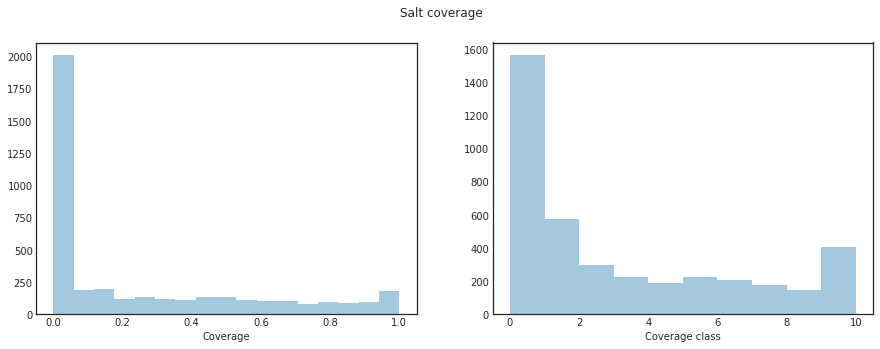

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

/home/endi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/endi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

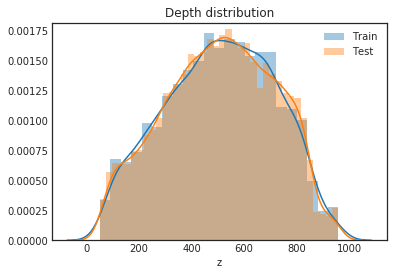

In [11]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [12]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,#ids
    np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1), #raw image
    np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1), #mask image (label of unet)
    train_df.coverage.values,#coverage (0~1)
    train_df.z.values,#depths
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [13]:
ACTIVATION = "relu"

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation(ACTIVATION)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation(ACTIVATION)(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [14]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation(ACTIVATION)(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation(ACTIVATION)(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [15]:
# evaluation metric of this competition
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (iou_thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

In [16]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [17]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

model = Model(input_layer, output_layer)

# convert to multi-gpu
#model = multi_gpu_model(model, gpus=2, cpu_merge=True, cpu_relocation=False)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [18]:
early_stopping = EarlyStopping(monitor='val_acc', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint("model/unet_best1.model",monitor='val_acc', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode = 'max',factor=0.2, patience=5, min_lr=0.00001, verbose=1)
#reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 42s 7ms/step - loss: 0.3769 - acc: 0.8558 - val_loss: 0.4536 - val_acc: 0.8613

Epoch 00001: val_acc improved from -inf to 0.86130, saving model to model/unet_best1.model
Epoch 2/200
6400/6400 [==============================] - 30s 5ms/step - loss: 0.2712 - acc: 0.9014 - val_loss: 0.3289 - val_acc: 0.9049

Epoch 00002: val_acc improved from 0.86130 to 0.90489, saving model to model/unet_best1.model
Epoch 3/200
6400/6400 [==============================] - 28s 4ms/step - loss: 0.2392 - acc: 0.9124 - val_loss: 0.3975 - val_acc: 0.8457

Epoch 00003: val_acc did not improve from 0.90489
Epoch 4/200
6400/6400 [==============================] - 29s 4ms/step - loss: 0.2186 - acc: 0.9194 - val_loss: 0.2106 - val_acc: 0.9247

Epoch 00004: val_acc improved from 0.90489 to 0.92473, saving model to model/unet_best1.model
Epoch 5/200
6400/6400 [==============================] - 29s 4ms/step - loss

6400/6400 [==============================] - 28s 4ms/step - loss: 0.0924 - acc: 0.9650 - val_loss: 0.1330 - val_acc: 0.9510

Epoch 00041: val_acc did not improve from 0.95146
Epoch 42/200
6400/6400 [==============================] - 29s 5ms/step - loss: 0.0901 - acc: 0.9663 - val_loss: 0.1338 - val_acc: 0.9511

Epoch 00042: val_acc did not improve from 0.95146
Epoch 43/200
6400/6400 [==============================] - 28s 4ms/step - loss: 0.0896 - acc: 0.9660 - val_loss: 0.1334 - val_acc: 0.9507

Epoch 00043: val_acc did not improve from 0.95146
Epoch 44/200
6400/6400 [==============================] - 28s 4ms/step - loss: 0.0883 - acc: 0.9670 - val_loss: 0.1358 - val_acc: 0.9510

Epoch 00044: val_acc did not improve from 0.95146
Epoch 45/200
6400/6400 [==============================] - 28s 4ms/step - loss: 0.0887 - acc: 0.9664 - val_loss: 0.1354 - val_acc: 0.9509

Epoch 00045: val_acc did not improve from 0.95146
Epoch 46/200
6400/6400 [==============================] - 28s 4ms/step - 

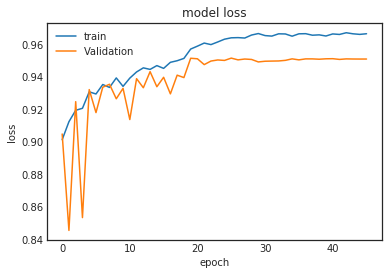

In [19]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['acc'][1:])
plt.plot(history.history['val_acc'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

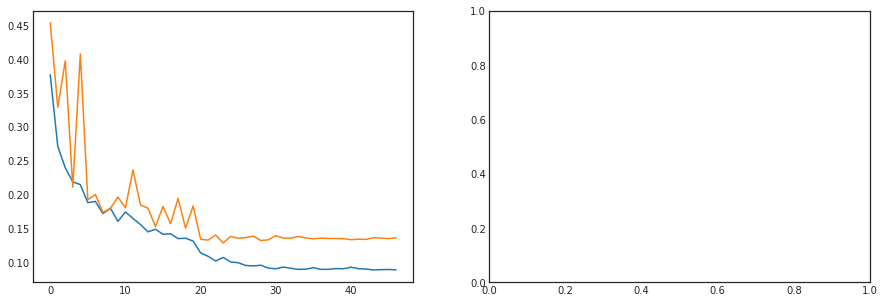

In [20]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")

In [21]:
model = load_model("model/unet_best1.model")

In [22]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test/2.0

preds_valid = predict_result(model,x_valid,img_size_target)

In [23]:
def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric(y_valid.reshape((-1, img_size_target, img_size_target)), \
                            [filter_image(img) for img in preds_valid > threshold]) \
                 for threshold in tqdm_notebook(thresholds)])

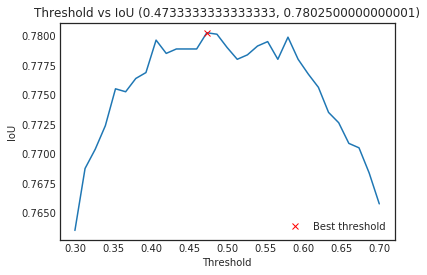

In [24]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [25]:
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [26]:
import gc

del x_train, x_valid, y_train, y_valid, preds_valid
gc.collect()

136554

In [28]:
x_test = np.array([(np.array(load_img("data/raw/test_images/images/{}.png".format(idx), \
                                      color_mode = "grayscale"))) / 255 \
                   for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = predict_result(model,x_test,img_size_target)

In [29]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(filter_image(preds_test[i] > threshold_best)) \
             for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

Usedtime = 2.4392123222351074 s


In [41]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub = sub.reset_index().rename(columns={'index':'id', 0:'rle_mask'})
sub.to_csv('submissions/0909_unet_v1.csv.gz', compression='gzip', index=False)

In [42]:
sub.head(10)

,id,rle_mask
0,353e010b7b,
1,5439dbbddf,
2,71bab9f311,
3,52551f7a80,
4,512d8d9997,2946 4 3046 5 3147 7 3248 9 3349 11 3449 15 35...
5,64dba827d6,
6,0a3a8a5f37,
7,329563756f,1 5251 5253 98 5354 98 5455 97 5556 97 5657 96...
8,f6cba2e890,
9,989c646373,1 4 14 1 37 6 54 20 102 1 104 3 113 3 139 5 15...
